# Medway - Parliamentary Constituencies - 1918

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import re
from IPython.core.display import HTML
from matplotlib import pyplot as plt
import json
from pywaffle import Waffle

In [2]:
# !mamba install pywaffle

In [3]:
with open('secrets/maptiler.json') as fh:
    api_key_maptiler = json.load(fh)['api_key']

In [4]:
consituencies = ['Chatham', 'Rochester', 'Medway', 'Maidstone', 'Rochester, Chatham', 'Rochester, Gillingham', 'Faversham', 'Sevenoaks', 'Gravesend']


gdf_1885 = (
    gpd.read_file('data/medway_historic_boundaries/1885_constituencies___england__south_.geojson')
    .loc[lambda _df: _df['Name'].isin(['Chatham', 'Rochester', 'Maidstone', 'Medway'])]
)

gdf_1918 = (
    gpd.read_file('data/medway_historic_boundaries/1918_constituencies___england__south_.geojson')
    .loc[lambda _df: _df['Name'].isin(['Chatham', 'Rochester', 'Medway', 'Maidstone', 'Rochester, Chatham', 'Rochester, Gillingham', 'Faversham', 'Sevenoaks', 'Gravesend'])]
)

/opt/conda/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 1045 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


In [5]:
gdf_1885

1885  1886  1892  1895  1900  1906     id       Name 1910(J) 1910(D)  \
76  None  None  None  None  None  None  587.0  Maidstone    None    None   
78  None  None  None  None  None  None  585.0  Rochester    None    None   
79  None  None  None  None  None  None  584.0    Chatham    None    None   
80  None  None  None  None  None  None  583.0     Medway    None    None   

                                             geometry  
76  POLYGON ((0.50875 51.28632, 0.51181 51.28495, ...  
78  POLYGON ((0.51163 51.37503, 0.51162 51.37416, ...  
79  POLYGON ((0.51769 51.38568, 0.5227 51.38739, 0...  
80  POLYGON ((0.39176 51.44837, 0.39306 51.4484, 0...

In [6]:
gdf_1918

id  fid                   Name  \
97   U3OTE  136              Faversham   
101  c4ODc  132     Rochester, Chatham   
102  ExNjQ  131              Gravesend   
103  MxNDc  130              Maidstone   
108  QyNDc  125  Rochester, Gillingham   
224  AyNjY    9              Sevenoaks   
225  A4Njc    8              Sevenoaks   

                                              geometry  
97   MULTIPOLYGON (((0.64577 51.41326, 0.64596 51.4...  
101  MULTIPOLYGON (((0.55811 51.37157, 0.55956 51.3...  
102  MULTIPOLYGON (((0.31692 51.46934, 0.317 51.469...  
103  MULTIPOLYGON (((0.38423 51.19826, 0.3843 51.19...  
108  MULTIPOLYGON (((0.55956 51.37037, 0.55811 51.3...  
224  MULTIPOLYGON (((0.05043 51.29399, 0.0505 51.29...  
225  MULTIPOLYGON (((0.24193 51.17957, 0.24006 51.1...

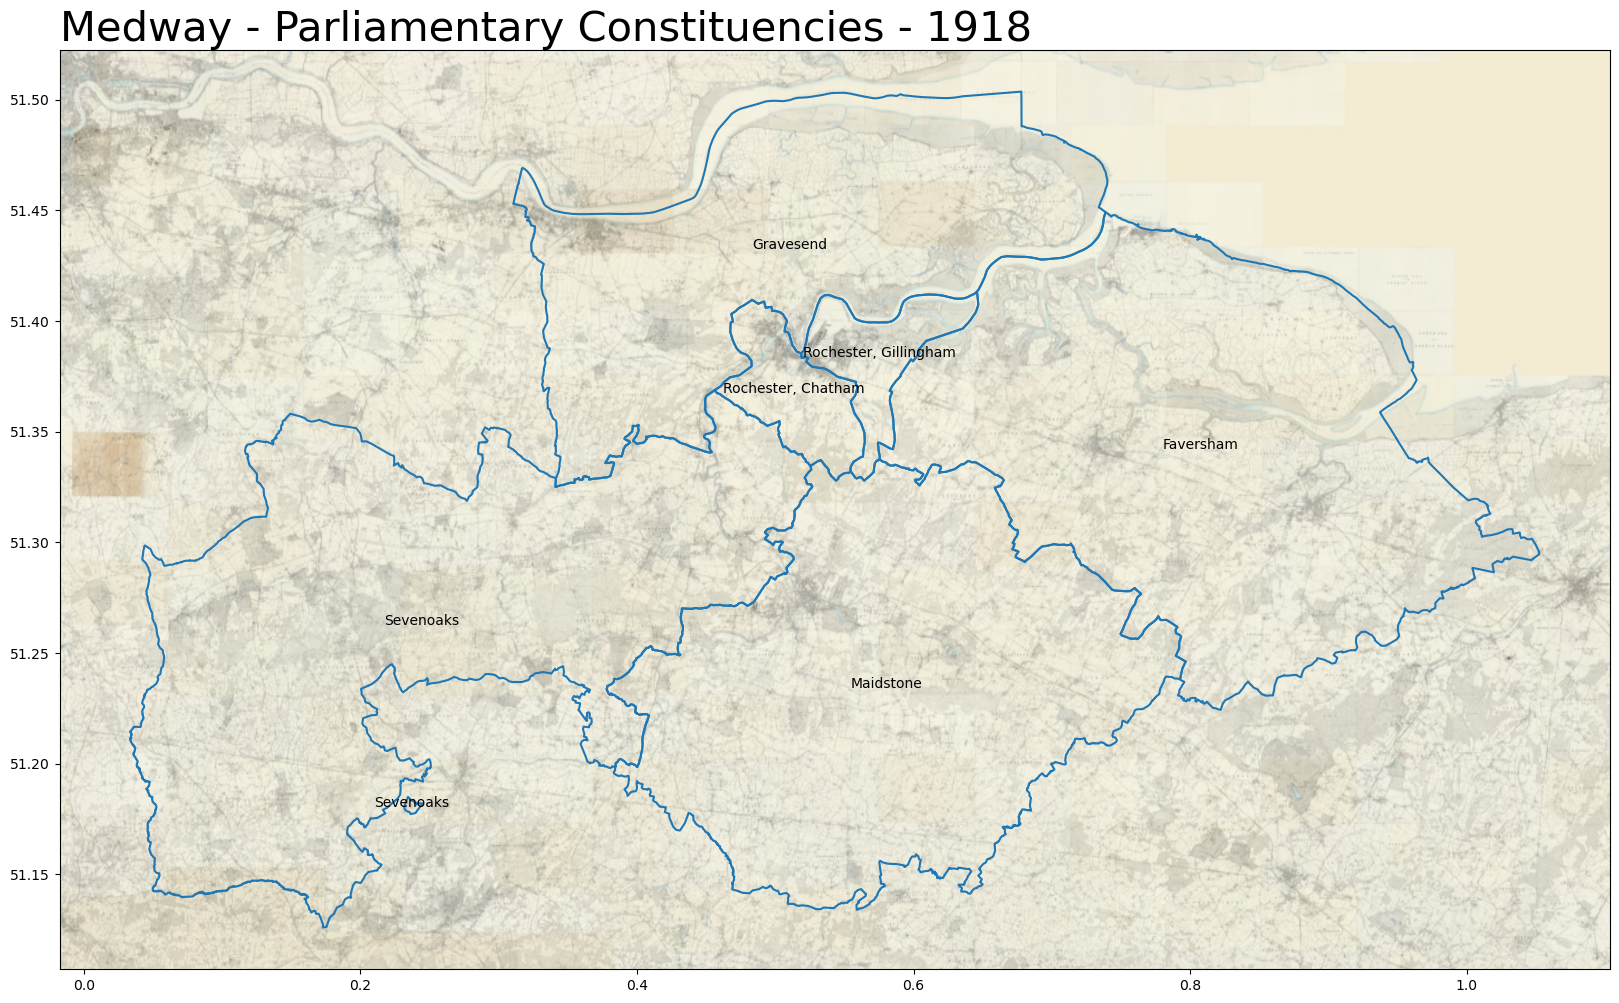

In [7]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20,20))


# Plot 1918

gdf_1918.boundary.plot(ax=ax)

cx.add_basemap(ax,crs=gdf_1918.crs, source=f"https://api.maptiler.com/tiles/uk-osgb10k1888/{{z}}/{{x}}/{{y}}.jpg?key={api_key_maptiler}", zoom=11)
gdf_1918.apply(lambda x: ax.annotate(text=x['Name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)

plt.title('Medway - Parliamentary Constituencies - 1918', loc='left', size=30)

plt.savefig('Medway - Parliamentary Constituencies - 1918.png', bbox_inches='tight')

In [8]:
map_constituency_1918 = {
    'ROCHESTER CHATHAM': 'Rochester, Chatham',
    'ROCHESTER GILLINGHAM': 'Rochester, Gillingham',
    "KENT FAVERSHAM": "Faversham",
    "KENT GRAVESEND": "Gravesend",
    "KENT MAIDSTONE": "Maidstone",
    "KENT SEVENOAKS": "Sevenoaks"
}

### How did they vote in 1918?
df_1918 = (
    pd.read_excel('data/1918-2019election_results_by_pcon.xlsx', header=[2,3], sheet_name='1918')    
    # Drop first column
    .pipe(lambda _df: _df.drop(_df.columns[0], axis=1))    
    # Merge multi-index
    .pipe(lambda _df: _df.set_axis(_df.columns.map('_'.join), axis=1))
    # Drop if column contains 'share' or 'share.1' - these are vote share percentage - we can recalculate these
    .pipe(lambda _df: _df.drop([c for c in _df.columns if re.search(r'(share|\.\d|Turnout)', c)], axis=1))    
    # Rename 'Unnamed' columns
    .pipe(lambda _df: _df.set_axis([re.sub(r'Unnamed: \d_level_\d_','',c) for c in _df.columns], axis=1))
    # Rename Total votes
    .rename(columns={'Other_Total votes': 'total_votes'})
    # Remove 'Votes' from party names
    .pipe(lambda _df: _df.set_axis([re.sub(r'_Votes','',c) for c in _df.columns], axis=1))
    # Strip party names
    .pipe(lambda _df: _df.set_axis([c.strip() for c in _df.columns], axis=1))
    # Select only Medway-ish towns
    .loc[lambda _df: _df['Constituency'].isin(['ROCHESTER CHATHAM', 'ROCHESTER GILLINGHAM', 'KENT GRAVESEND', 'KENT SEVENOAKS', 'KENT MAIDSTONE', 'KENT FAVERSHAM' ])]
    .assign(**{'constituency': lambda _df: _df['Constituency'].map(map_constituency_1918)})
    .dropna(axis=1, how='all')
)

df_1918


id Seats          Constituency County Country/Region  Electorate  \
193  214.0     1     ROCHESTER CHATHAM   Kent     South East     31000.0   
194  215.0     1  ROCHESTER GILLINGHAM   Kent     South East     27899.0   
335  368.0     1        KENT FAVERSHAM   Kent     South East     37478.0   
336  369.0     1        KENT GRAVESEND   Kent     South East     31070.0   
338  371.0     1        KENT MAIDSTONE   Kent     South East     30747.0   
339  373.0     1        KENT SEVENOAKS   Kent     South East     30189.0   

     Conservative Party  Liberal  Labour  Independent Labour  \
193             11454.0   2778.0  4134.0                 NaN   
194             12455.0      NaN  4705.0                 NaN   
335             12826.0      NaN  5981.0                 NaN   
336              7841.0   1271.0  3254.0                 NaN   
338             11931.0      NaN  6277.0                 NaN   
339             10650.0      NaN     NaN              3323.0   

     Independent Conservative  Independent  National  total_votes  \
193                       NaN          NaN       NaN      18366.0   
194                       NaN       1001.0       NaN      18161.0   
335                       NaN          NaN       NaN      18807.0   
336                    1817.0          NaN     985.0      15168.0   
338                       NaN          NaN       NaN      18208.0   
339                       NaN          NaN       NaN      13973.0   

              constituency  
193     Rochester, Chatham  
194  Rochester, Gillingham  
335              Faversham  
336              Gravesend  
338              Maidstone  
339              Sevenoaks

In [9]:
map_party_colors = {
    "Conservative Party": "#0575C9",
    "Liberal" : "#FF9A02",
    "Labour": "#E91D0E",
    "Independent Labour": "#cd0000",
    "Independent Conservative" : "#6495ED",
    "National": "#0000AE",
    "Independent National": "#00008B",    
    "Independent": "#BABABA"
}

id Seats    Constituency County Country/Region  Electorate  \
335  368.0     1  KENT FAVERSHAM   Kent     South East     37478.0   

     Conservative Party  Liberal  Labour  Independent Labour  \
335             12826.0      NaN  5981.0                 NaN   

     Independent Conservative  Independent  National  total_votes constituency  
335                       NaN          NaN       NaN      18807.0    Faversham

id Seats  Electorate  total_votes constituency    Constituency County  \
2  368.0     1     37478.0      18807.0    Faversham  KENT FAVERSHAM   Kent   
0  368.0     1     37478.0      18807.0    Faversham  KENT FAVERSHAM   Kent   

  Country/Region               party    votes  vote_perc party_color  
2     South East              Labour   5981.0    0.31802     #E91D0E  
0     South East  Conservative Party  12826.0    0.68198     #0575C9

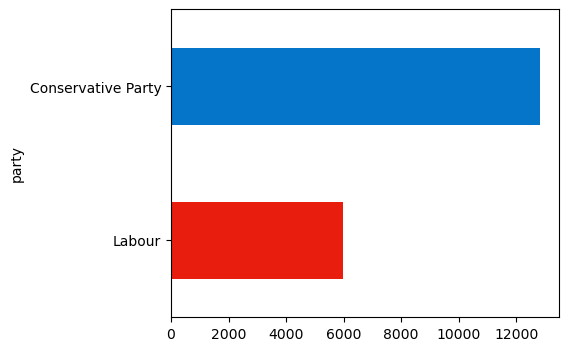

id Seats    Constituency County Country/Region  Electorate  \
336  369.0     1  KENT GRAVESEND   Kent     South East     31070.0   

     Conservative Party  Liberal  Labour  Independent Labour  \
336              7841.0   1271.0  3254.0                 NaN   

     Independent Conservative  Independent  National  total_votes constituency  
336                    1817.0          NaN     985.0      15168.0    Gravesend

id Seats  Electorate  total_votes constituency    Constituency County  \
6  369.0     1     31070.0      15168.0    Gravesend  KENT GRAVESEND   Kent   
1  369.0     1     31070.0      15168.0    Gravesend  KENT GRAVESEND   Kent   
4  369.0     1     31070.0      15168.0    Gravesend  KENT GRAVESEND   Kent   
2  369.0     1     31070.0      15168.0    Gravesend  KENT GRAVESEND   Kent   
0  369.0     1     31070.0      15168.0    Gravesend  KENT GRAVESEND   Kent   

  Country/Region                     party   votes  vote_perc party_color  
6     South East                  National   985.0   0.064939     #0000AE  
1     South East                   Liberal  1271.0   0.083795     #FF9A02  
4     South East  Independent Conservative  1817.0   0.119792     #6495ED  
2     South East                    Labour  3254.0   0.214531     #E91D0E  
0     South East        Conservative Party  7841.0   0.516944     #0575C9

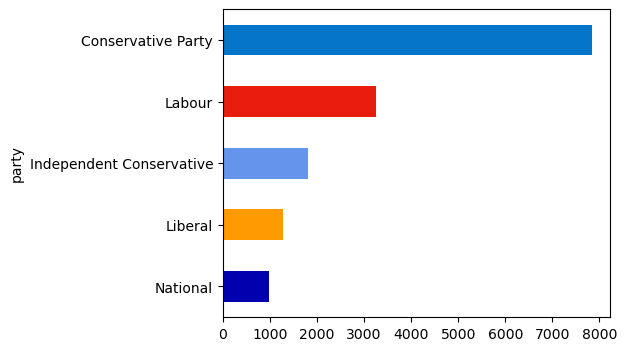

id Seats    Constituency County Country/Region  Electorate  \
338  371.0     1  KENT MAIDSTONE   Kent     South East     30747.0   

     Conservative Party  Liberal  Labour  Independent Labour  \
338             11931.0      NaN  6277.0                 NaN   

     Independent Conservative  Independent  National  total_votes constituency  
338                       NaN          NaN       NaN      18208.0    Maidstone

id Seats  Electorate  total_votes constituency    Constituency County  \
2  371.0     1     30747.0      18208.0    Maidstone  KENT MAIDSTONE   Kent   
0  371.0     1     30747.0      18208.0    Maidstone  KENT MAIDSTONE   Kent   

  Country/Region               party    votes  vote_perc party_color  
2     South East              Labour   6277.0   0.344739     #E91D0E  
0     South East  Conservative Party  11931.0   0.655261     #0575C9

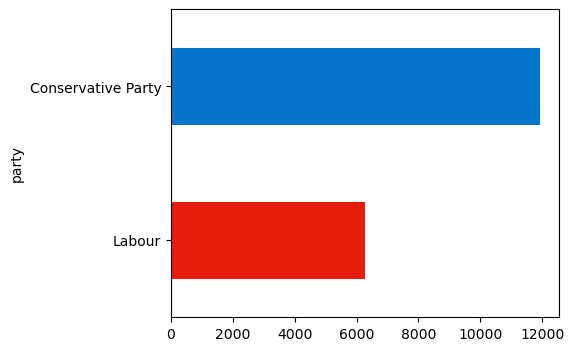

id Seats       Constituency County Country/Region  Electorate  \
193  214.0     1  ROCHESTER CHATHAM   Kent     South East     31000.0   

     Conservative Party  Liberal  Labour  Independent Labour  \
193             11454.0   2778.0  4134.0                 NaN   

     Independent Conservative  Independent  National  total_votes  \
193                       NaN          NaN       NaN      18366.0   

           constituency  
193  Rochester, Chatham

id Seats  Electorate  total_votes        constituency  \
1  214.0     1     31000.0      18366.0  Rochester, Chatham   
2  214.0     1     31000.0      18366.0  Rochester, Chatham   
0  214.0     1     31000.0      18366.0  Rochester, Chatham   

        Constituency County Country/Region               party    votes  \
1  ROCHESTER CHATHAM   Kent     South East             Liberal   2778.0   
2  ROCHESTER CHATHAM   Kent     South East              Labour   4134.0   
0  ROCHESTER CHATHAM   Kent     South East  Conservative Party  11454.0   

   vote_perc party_color  
1   0.151258     #FF9A02  
2   0.225090     #E91D0E  
0   0.623652     #0575C9

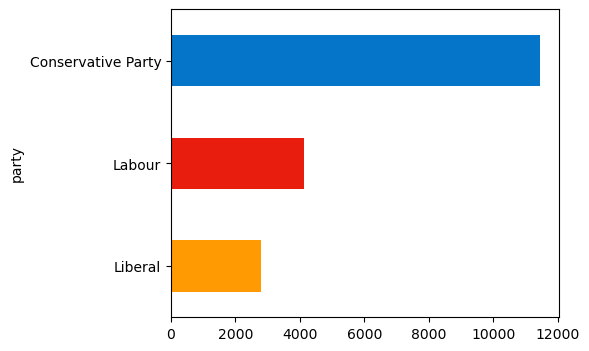

id Seats          Constituency County Country/Region  Electorate  \
194  215.0     1  ROCHESTER GILLINGHAM   Kent     South East     27899.0   

     Conservative Party  Liberal  Labour  Independent Labour  \
194             12455.0      NaN  4705.0                 NaN   

     Independent Conservative  Independent  National  total_votes  \
194                       NaN       1001.0       NaN      18161.0   

              constituency  
194  Rochester, Gillingham

id Seats  Electorate  total_votes           constituency  \
5  215.0     1     27899.0      18161.0  Rochester, Gillingham   
2  215.0     1     27899.0      18161.0  Rochester, Gillingham   
0  215.0     1     27899.0      18161.0  Rochester, Gillingham   

           Constituency County Country/Region               party    votes  \
5  ROCHESTER GILLINGHAM   Kent     South East         Independent   1001.0   
2  ROCHESTER GILLINGHAM   Kent     South East              Labour   4705.0   
0  ROCHESTER GILLINGHAM   Kent     South East  Conservative Party  12455.0   

   vote_perc party_color  
5   0.055118     #BABABA  
2   0.259072     #E91D0E  
0   0.685810     #0575C9

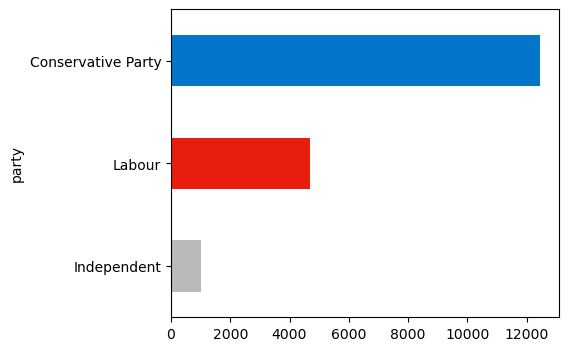

id Seats    Constituency County Country/Region  Electorate  \
339  373.0     1  KENT SEVENOAKS   Kent     South East     30189.0   

     Conservative Party  Liberal  Labour  Independent Labour  \
339             10650.0      NaN     NaN              3323.0   

     Independent Conservative  Independent  National  total_votes constituency  
339                       NaN          NaN       NaN      13973.0    Sevenoaks

id Seats  Electorate  total_votes constituency    Constituency County  \
3  373.0     1     30189.0      13973.0    Sevenoaks  KENT SEVENOAKS   Kent   
0  373.0     1     30189.0      13973.0    Sevenoaks  KENT SEVENOAKS   Kent   

  Country/Region               party    votes  vote_perc party_color  
3     South East  Independent Labour   3323.0   0.237816     #cd0000  
0     South East  Conservative Party  10650.0   0.762184     #0575C9

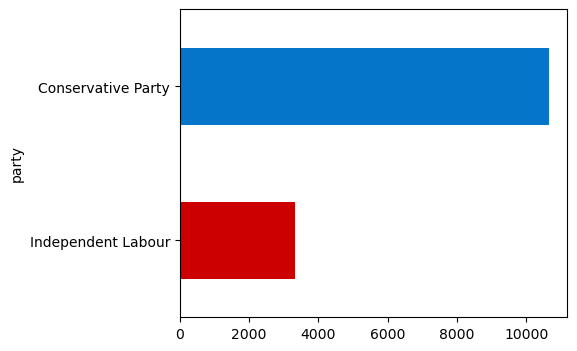

In [10]:
for constituency in sorted(df_1918['constituency'].unique()):
    fig, ax = plt.subplots(figsize=(5,4))
    display(HTML(f'<h2>{constituency}</h2>'))
    display(df_1918.loc[lambda _df: _df['constituency'] == constituency])
    df_local = (
        df_1918.loc[lambda _df: _df['constituency'] == constituency].melt(id_vars=['id', 'Seats', 'Electorate', 'total_votes', 'constituency', 'Constituency','County', 'Country/Region'])        
        .rename(columns={'variable': 'party', 'value': 'votes'})
        .dropna(subset=['votes'])
        .assign(**{
            'vote_perc': lambda _df: _df['votes'] / _df['total_votes'],
            'party_color': lambda _df: _df['party'].map(map_party_colors)
        })
        .sort_values('votes', ascending=True)
    )
    display(df_local)
    df_local.plot.barh(ax=ax, y='votes', x='party', color=df_local['party_color'], legend=None)
    plt.show()

In [11]:
# Map winning party
df_party_winner = (
    df_1918
    .melt(id_vars=['id', 'Seats', 'Electorate', 'total_votes', 'constituency', 'Constituency','County', 'Country/Region'])        
        .rename(columns={'variable': 'party', 'value': 'votes'})
        .dropna(subset=['votes'])
        .assign(**{
            'vote_perc': lambda _df: _df['votes'] / _df['total_votes'],
            'party_color': lambda _df: _df['party'].map(map_party_colors),
        })
    .sort_values('votes', ascending=True)    
    .groupby(['constituency'])[['party', 'votes']].apply(lambda x: x.loc[x['votes'].idxmax(), 'party'])
    .reset_index()
    .rename(columns={0: 'party_winner'})
)

df_party_winner

constituency        party_winner
0              Faversham  Conservative Party
1              Gravesend  Conservative Party
2              Maidstone  Conservative Party
3     Rochester, Chatham  Conservative Party
4  Rochester, Gillingham  Conservative Party
5              Sevenoaks  Conservative Party

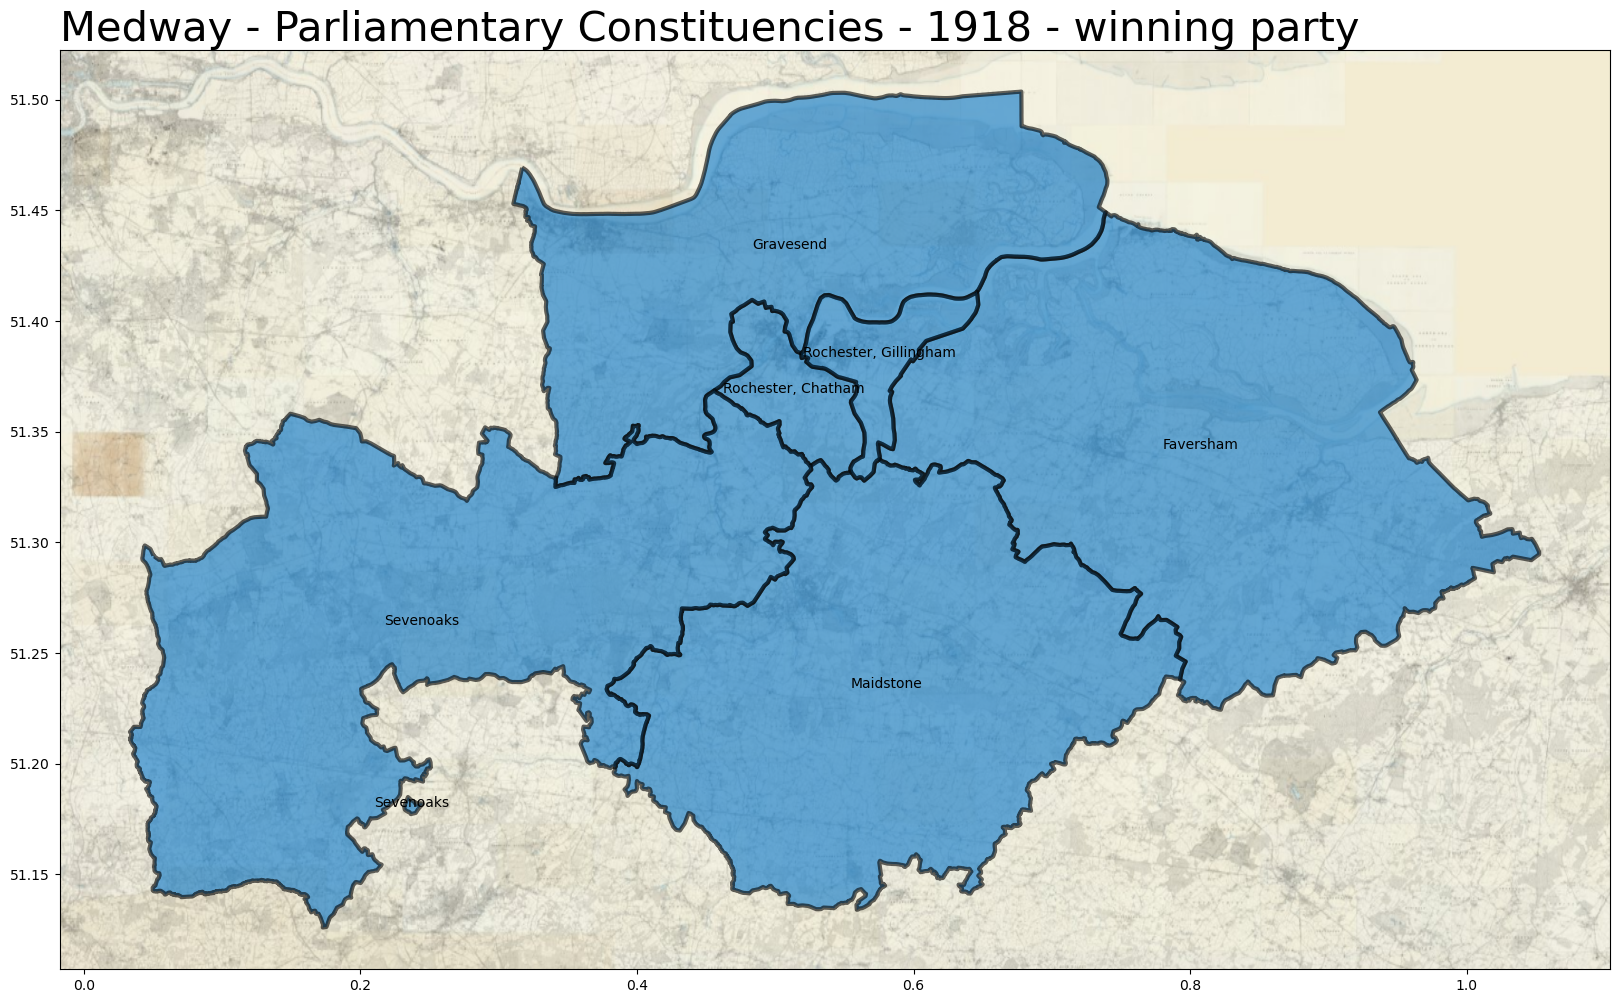

In [12]:
# Plot 1918 - with winning party
fig, ax = plt.subplots(figsize=(20,20))

(
    pd.merge(
        gdf_1918,
        df_party_winner,
        left_on='Name',
        right_on='constituency'
    )
    .assign(**{
        'party_color': lambda _df: _df['party_winner'].map(map_party_colors)
    })
).pipe(lambda _df: _df.plot(ax=ax, color=_df['party_color'], linewidth=3, edgecolor='black', alpha=.6, ))
    
# .boundary.plot(ax=ax)
cx.add_basemap(ax,crs=gdf_1918.crs, source=f"https://api.maptiler.com/tiles/uk-osgb10k1888/{{z}}/{{x}}/{{y}}.jpg?key={api_key_maptiler}", zoom=11)
gdf_1918.apply(lambda x: ax.annotate(text=x['Name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
# plt.legend([], loc='best', title='Legend Title')

plt.title('Medway - Parliamentary Constituencies - 1918 - winning party', loc='left', size=30)

plt.savefig('Medway - Parliamentary Constituencies - 1918 - winning party.png', bbox_inches='tight')

In [13]:
# !mamba install -y pywaffle

constituency              votes              \
party                        Conservative Party Independent   
0                  Faversham            12826.0         0.0   
1                  Gravesend             7841.0         0.0   
2                  Maidstone            11931.0         0.0   
3         Rochester, Chatham            11454.0         0.0   
4      Rochester, Gillingham            12455.0      1001.0   
5                  Sevenoaks            10650.0         0.0   

                                                                            
party Independent Conservative Independent Labour  Labour Liberal National  
0                          0.0                0.0  5981.0     0.0      0.0  
1                       1817.0                0.0  3254.0  1271.0    985.0  
2                          0.0                0.0  6277.0     0.0      0.0  
3                          0.0                0.0  4134.0  2778.0      0.0  
4                          0.0                0.0  4705.0     0.0      0.0  
5                          0.0             3323.0     0.0     0.0      0.0

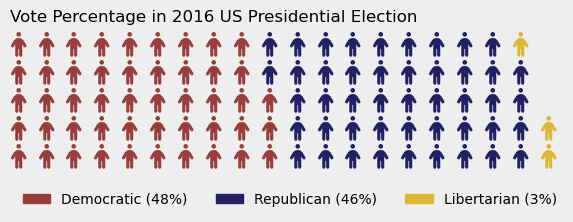

In [14]:
df_local = (
    df_1918
    .melt(id_vars=['id', 'Seats', 'Electorate', 'total_votes', 'constituency', 'Constituency','County', 'Country/Region'])        
        .rename(columns={'variable': 'party', 'value': 'votes'})
        .dropna(subset=['votes'])
        .assign(**{
            'vote_perc': lambda _df: _df['votes'] / _df['total_votes'],
            'party_color': lambda _df: _df['party'].map(map_party_colors),
        })
    # .sort_values('votes', ascending=True)    
    # .groupby(['constituency'])[['party', 'votes']].apply(lambda x: x.loc[x['votes'].idxmax(), 'party'])
    # .reset_index()
    # .rename(columns={0: 'party_winner'})
)

display(df_local.pivot_table(values=['votes'] , index=['constituency'], columns='party', aggfunc='sum').fillna(0).reset_index())

data = {'Democratic': 48, 'Republican': 46, 'Libertarian': 3}
fig = plt.figure(
    FigureClass=Waffle, 
    rows=5, 
    values=data, 
    colors=("#983D3D", "#232066", "#DCB732"),
    title={'label': 'Vote Percentage in 2016 US Presidential Election', 'loc': 'left'},
    labels=["{0} ({1}%)".format(k, v) for k, v in data.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.4), 'ncol': len(data), 'framealpha': 0},
    icons="person", icon_size=18,
)
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
plt.show()

In [15]:
df_local = (
    df_1918
    .melt(id_vars=['id', 'Seats', 'Electorate', 'total_votes', 'constituency', 'Constituency','County', 'Country/Region'])        
        .rename(columns={'variable': 'party', 'value': 'votes'})
        .dropna(subset=['votes'])
)

# df_local[df_local['constituency'] == 'Faversham'][['party', 'votes']].assign(**{'votes': lambda _df: _df['votes'] // 1000}).set_index('party')

df_local
# ["{0} ({1})".format(n, v) for n, v in df_local[df_local['constituency'] == 'Faversham'][['constituency', 'votes']].assign(**{'votes': lambda _df: _df['votes'] // 1000}).items()],

id Seats  Electorate  total_votes           constituency  \
0   214.0     1     31000.0      18366.0     Rochester, Chatham   
1   215.0     1     27899.0      18161.0  Rochester, Gillingham   
2   368.0     1     37478.0      18807.0              Faversham   
3   369.0     1     31070.0      15168.0              Gravesend   
4   371.0     1     30747.0      18208.0              Maidstone   
5   373.0     1     30189.0      13973.0              Sevenoaks   
6   214.0     1     31000.0      18366.0     Rochester, Chatham   
9   369.0     1     31070.0      15168.0              Gravesend   
12  214.0     1     31000.0      18366.0     Rochester, Chatham   
13  215.0     1     27899.0      18161.0  Rochester, Gillingham   
14  368.0     1     37478.0      18807.0              Faversham   
15  369.0     1     31070.0      15168.0              Gravesend   
16  371.0     1     30747.0      18208.0              Maidstone   
23  373.0     1     30189.0      13973.0              Sevenoaks   
27  369.0     1     31070.0      15168.0              Gravesend   
31  215.0     1     27899.0      18161.0  Rochester, Gillingham   
39  369.0     1     31070.0      15168.0              Gravesend   

            Constituency County Country/Region                     party  \
0      ROCHESTER CHATHAM   Kent     South East        Conservative Party   
1   ROCHESTER GILLINGHAM   Kent     South East        Conservative Party   
2         KENT FAVERSHAM   Kent     South East        Conservative Party   
3         KENT GRAVESEND   Kent     South East        Conservative Party   
4         KENT MAIDSTONE   Kent     South East        Conservative Party   
5         KENT SEVENOAKS   Kent     South East        Conservative Party   
6      ROCHESTER CHATHAM   Kent     South East                   Liberal   
9         KENT GRAVESEND   Kent     South East                   Liberal   
12     ROCHESTER CHATHAM   Kent     South East                    Labour   
13  ROCHESTER GILLINGHAM   Kent     South East                    Labour   
14        KENT FAVERSHAM   Kent     South East                    Labour   
15        KENT GRAVESEND   Kent     South East                    Labour   
16        KENT MAIDSTONE   Kent     South East                    Labour   
23        KENT SEVENOAKS   Kent     South East        Independent Labour   
27        KENT GRAVESEND   Kent     South East  Independent Conservative   
31  ROCHESTER GILLINGHAM   Kent     South East               Independent   
39        KENT GRAVESEND   Kent     South East                  National   

      votes  
0   11454.0  
1   12455.0  
2   12826.0  
3    7841.0  
4   11931.0  
5   10650.0  
6    2778.0  
9    1271.0  
12   4134.0  
13   4705.0  
14   5981.0  
15   3254.0  
16   6277.0  
23   3323.0  
27   1817.0  
31   1001.0  
39    985.0

id Seats  Electorate  total_votes           constituency  \
0   214.0     1     31000.0      18366.0     Rochester, Chatham   
1   215.0     1     27899.0      18161.0  Rochester, Gillingham   
2   368.0     1     37478.0      18807.0              Faversham   
3   369.0     1     31070.0      15168.0              Gravesend   
4   371.0     1     30747.0      18208.0              Maidstone   
5   373.0     1     30189.0      13973.0              Sevenoaks   
6   214.0     1     31000.0      18366.0     Rochester, Chatham   
9   369.0     1     31070.0      15168.0              Gravesend   
12  214.0     1     31000.0      18366.0     Rochester, Chatham   
13  215.0     1     27899.0      18161.0  Rochester, Gillingham   
14  368.0     1     37478.0      18807.0              Faversham   
15  369.0     1     31070.0      15168.0              Gravesend   
16  371.0     1     30747.0      18208.0              Maidstone   
23  373.0     1     30189.0      13973.0              Sevenoaks   
27  369.0     1     31070.0      15168.0              Gravesend   
31  215.0     1     27899.0      18161.0  Rochester, Gillingham   
39  369.0     1     31070.0      15168.0              Gravesend   

            Constituency County Country/Region                     party  \
0      ROCHESTER CHATHAM   Kent     South East        Conservative Party   
1   ROCHESTER GILLINGHAM   Kent     South East        Conservative Party   
2         KENT FAVERSHAM   Kent     South East        Conservative Party   
3         KENT GRAVESEND   Kent     South East        Conservative Party   
4         KENT MAIDSTONE   Kent     South East        Conservative Party   
5         KENT SEVENOAKS   Kent     South East        Conservative Party   
6      ROCHESTER CHATHAM   Kent     South East                   Liberal   
9         KENT GRAVESEND   Kent     South East                   Liberal   
12     ROCHESTER CHATHAM   Kent     South East                    Labour   
13  ROCHESTER GILLINGHAM   Kent     South East                    Labour   
14        KENT FAVERSHAM   Kent     South East                    Labour   
15        KENT GRAVESEND   Kent     South East                    Labour   
16        KENT MAIDSTONE   Kent     South East                    Labour   
23        KENT SEVENOAKS   Kent     South East        Independent Labour   
27        KENT GRAVESEND   Kent     South East  Independent Conservative   
31  ROCHESTER GILLINGHAM   Kent     South East               Independent   
39        KENT GRAVESEND   Kent     South East                  National   

      votes  vote_perc party_color  
0   11454.0   0.623652     #0575C9  
1   12455.0   0.685810     #0575C9  
2   12826.0   0.681980     #0575C9  
3    7841.0   0.516944     #0575C9  
4   11931.0   0.655261     #0575C9  
5   10650.0   0.762184     #0575C9  
6    2778.0   0.151258     #FF9A02  
9    1271.0   0.083795     #FF9A02  
12   4134.0   0.225090     #E91D0E  
13   4705.0   0.259072     #E91D0E  
14   5981.0   0.318020     #E91D0E  
15   3254.0   0.214531     #E91D0E  
16   6277.0   0.344739     #E91D0E  
23   3323.0   0.237816     #cd0000  
27   1817.0   0.119792     #6495ED  
31   1001.0   0.055118     #BABABA  
39    985.0   0.064939     #0000AE

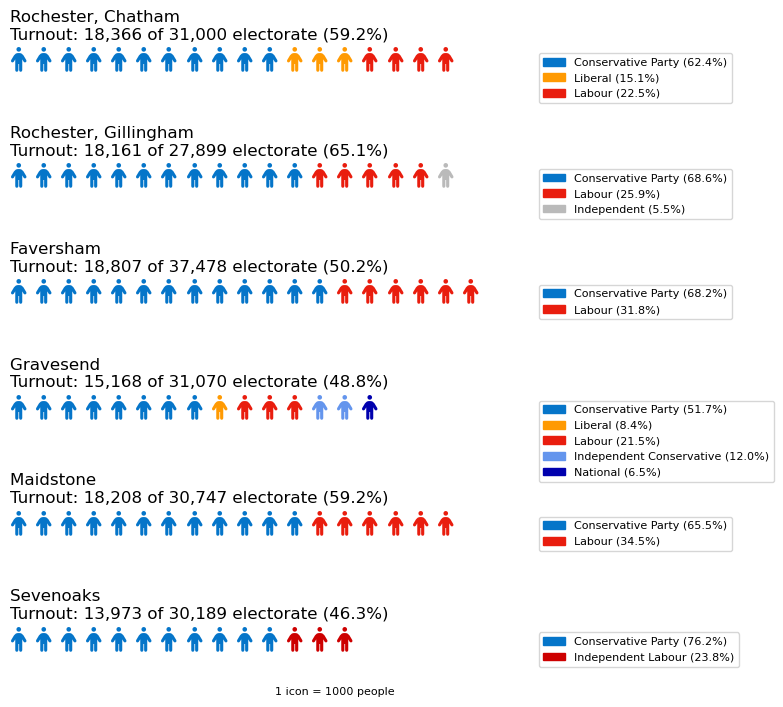

In [16]:
# display(df_local.pivot_table(values=['votes'] , index=['constituency'], columns='party', aggfunc='sum').fillna(0).reset_index())
# https://stackoverflow.com/questions/41400136/how-to-do-waffle-charts-in-python-square-piechart# https://stackoverflow.com/questions/41400136/how-to-do-waffle-charts-in-python-square-piechart# https://stackoverflow.com/questions/41400136/how-to-do-waffle-charts-in-python-square-piechart
df_local = (
    df_1918
    .melt(id_vars=['id', 'Seats', 'Electorate', 'total_votes', 'constituency', 'Constituency','County', 'Country/Region'])        
        .rename(columns={'variable': 'party', 'value': 'votes'})
        .dropna(subset=['votes'])
        .assign(**{
            'vote_perc': lambda _df: _df['votes'] / _df['total_votes'],
            'party_color': lambda _df: _df['party'].map(map_party_colors),
        })
    
)

def get_plots(_df_local):
    display(_df_local)    
    
    n_rows = len(_df_local['constituency'].unique())
    n_cols = 1
    
    plots = {}
    for i,constituency in enumerate(_df_local['constituency'].unique(), start=1):
        _df = _df_local[_df_local['constituency']==constituency]
        
        electorate = _df['Electorate'].max()
        total_votes = _df['total_votes'].max()

        plots[(n_rows, n_cols, i)] = {
            'values': _df['votes'] / 1000,  # Convert actual number to a reasonable block number,
            'colors': list(_df['party_color']),
            'labels': [f"{p} ({v*100:,.1f}%)" for p, v in zip(list(_df['party']),list(_df['vote_perc']))],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': f"{constituency} \nTurnout: {int(total_votes):,.0f} of {int(electorate):,.0f} electorate ({total_votes/electorate*100:0.1f}%)", 'loc': 'left', 'fontsize': 12},
            'suptitle': 'Foo'
        }
    return plots

fig = plt.figure(
    FigureClass=Waffle,
    plots=get_plots(df_local),
    # rows=1,  # Outside parameter applied to all subplots, same as below
    columns = 20,
    cmap_name="Accent",  # Change color with cmap
    # rounding_rule='ceil',  # Change rounding rule, so value less than 1000 will still have at least 1 block
    figsize=(8, 7),
    icons="person", icon_size=18,
)

display(HTML('<h1>General Election 1918</h1>'))
display(HTML('<h2>Parliamentary Constituencies of Medway, Kent</h2>'))
fig.supxlabel('1 icon = 1000 people', fontsize=8, ha='right')
plt.show()